In [1]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pycountry

In [2]:
pd.set_option('display.max_rows', None)

#### Fetch the UCI Online Retail dataset using its dataset ID (352) from the UCI repository

In [3]:
online_retail = fetch_ucirepo(id=352)  

<b>-></b> Check the structure of the returned object (returned data type: <b>dataset dictionary</b>) <br>
<b>-></b> Get top-level keys of the dataset dictionary (e.g., data, metadata, etc.) <br>
<b>-></b> Check keys within the 'data' dictionary to see available components

In [4]:
print(type(online_retail))
print(online_retail.keys())
print(online_retail.data.keys())

<class 'ucimlrepo.dotdict.dotdict'>
dict_keys(['data', 'metadata', 'variables'])
dict_keys(['ids', 'features', 'targets', 'original', 'headers'])


#### Load dataset

In [5]:
df_retail_raw = online_retail.data.original

<b>-></b> Check summary of the online retail dataset, for data types, and non-null counts for each column

In [6]:
df_retail_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


<b>-></b> Generate summary statistics for numerical columns

In [7]:
df_retail_raw.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


<b>-></b> Define a function to calculate the percentage of missing values for each column

In [8]:
def calc_misisng_percent(df):
    perc_missing_data = df.isna().sum()/len(df)
    df_perc_missing = perc_missing_data.reset_index()
    df_perc_missing.columns = ['Column', '%MissingValues']
    return(df_perc_missing)

<b>-></b> Call the calc_misisng_percent function to check missing value stats across the dataset

In [9]:
calc_misisng_percent(df_retail_raw)

,Column,%MissingValues
0,InvoiceNo,0.000000
1,StockCode,0.000000
2,Description,0.002683
3,Quantity,0.000000
4,InvoiceDate,0.000000
5,UnitPrice,0.000000
6,CustomerID,0.249267
7,Country,0.000000


<b>-></b> Check if canceled transactions (invoices starting with 'C') had corresponding non-canceled original invoices

In [10]:
# Filter out cancelled invoices
cancelled_invoices = df_retail_raw[df_retail_raw['InvoiceNo'].str.startswith('C')].copy()

# Extract only the numeric part by removing the 'C' prefix from the invoice number
cancelled_invoices['NumericInvoiceNo'] = cancelled_invoices['InvoiceNo'].str[1:]

# Create a list of invoice numbers that do not start with 'C'
valid_invoices = df_retail_raw[~df_retail_raw['InvoiceNo'].str.startswith('C')]['InvoiceNo']

# Find the match of each cancelled invoice with the corresponding non-cancelled invoice
invoice_matched = cancelled_invoices['NumericInvoiceNo'].isin(valid_invoices)

print("Total cancelled invoices: ", cancelled_invoices.shape[0])
print("Total number of original invoices exist for the cancelled invoices:", invoice_matched.sum())

Total cancelled invoices:  9288
Total number of original invoices exist for the cancelled invoices: 0


#### Data Cleaning
<b>-></b> Remove all records with cancelled invoices based on the finding that they do not have matching valid invoices

In [11]:
df_retail_clean = df_retail_raw[~df_retail_raw['InvoiceNo'].str.startswith('C')].copy()

In [12]:
df_retail_clean[df_retail_clean['InvoiceNo'].str.match(r'^[A-Za-z]')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299982,A563185,B,Adjust bad debt,1,8/12/2011 14:50,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,8/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,8/12/2011 14:52,-11062.06,NaN,United Kingdom


<b>-></b> Check if an any other invoice begins with letter instead of digits and remove them

In [13]:
print('Invoice numbers which begins with letters: ', np.array(df_retail_clean[df_retail_clean['InvoiceNo'].str.match(r'^[A-Za-z]')]['InvoiceNo']))

Invoice numbers which begins with letters:  ['A563185' 'A563186' 'A563187']


In [14]:
df_retail_clean = df_retail_clean[~df_retail_clean['InvoiceNo'].str.match(r'^[A-Za-z]')].copy()

<b>-></b> Remove all records with negative quantities

In [15]:
df_retail_clean = df_retail_clean[df_retail_clean['Quantity'] > 0].copy()

<b>-></b> Fill missing CustomerID with value -1 to retain these rows for Market Basket Analysis (MBA) <br>
<b>-></b> These rows will be excluded from RFM segmentation, where a valid customer ID is required

In [16]:
df_retail_clean['CustomerID'] = df_retail_clean['CustomerID'].fillna(-1)

<b>-></b> Replace missing product descriptions with 'Not Available' to maintain complete transaction records without dropping rows unnecessarily <br>
<b>-></b> This ensures all items have a label for visualizations and Market Basket Analysis

In [17]:
df_retail_clean['Description'] = df_retail_clean['Description'].fillna('Not Available')

<b>-></b> Check for transactions where UnitPrice == 0 and CustomerID == -1 and exclude them from the dataset <br>
<b>-></b> This combination is suggestive of non-sales activities, such as:
* Internal system tests
* Bad debt adjustments
* Inventory corrections

In [18]:
df_retail_clean = df_retail_clean[~((df_retail_clean['UnitPrice']==0) & (df_retail_clean['CustomerID'] == -1))].copy()

##### Duplicate Detection

In [19]:
print('Total number of duplicate records: ', int(df_retail_clean.duplicated().sum()))

Total number of duplicate records:  5226


<b>-></b> Remove duplicate records based on the assumption that they represent repeated entries rather than valid transactions. <br>
<b>-></b> This ensures each transaction line is unique and avoids skewed analysis.

In [20]:
df_retail_clean = df_retail_clean[~df_retail_clean.duplicated()].copy()

#### Data Preparation
<b>-></b> To analyze sales trends over time, converted the InvoiceDate column to a proper datetime format and extracted Year and Month as separate features.

In [21]:
df_retail_clean['InvoiceDate'] = pd.to_datetime(df_retail_clean['InvoiceDate'], format='%m/%d/%Y %H:%M')
df_retail_clean['Year'] = df_retail_clean['InvoiceDate'].dt.year
df_retail_clean['Month'] = df_retail_clean['InvoiceDate'].dt.month

<b>-></b> Create a new column for total price

In [22]:
df_retail_clean['Total Price'] = df_retail_clean['Quantity'] * df_retail_clean['UnitPrice']

<b>-></b> Standardizing Country Names

In [23]:
# Check all unique country names in the dataset
print('Distinct countries in online retail dataset: ', df_retail_clean['Country'].unique())

# Create a list of valid ISO country names using the pycountry library
valid_country_lst = [country.name for country in pycountry.countries]

# Check how many rows are labeled as 'Unspecified'
print("\n Number of rows with country name as 'Unspecified': ", df_retail_clean[df_retail_clean['Country'] == 'Unspecified'].shape[0])

Distinct countries in online retail dataset:  ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Finland' 'Austria' 'Bahrain' 'Israel' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']

 Number of rows with country name as 'Unspecified':  442


<b>-></b> Replace 'European Community' with 'Unspecified' and keep all records with 'Unspecified' country name to preserve complete sales and customer data for non-geographic analyses like product trends, RFM, and Market Basket Analysis.

In [24]:
# Standardize inconsistent or outdated country names
replacement_country = {
    'EIRE': 'Ireland',
    'Czech Republic': 'Czechia',
    'USA': 'United States',
    'RSA': 'South Africa',
    'European Community': 'Unspecified',
    'Channel Islands': 'United Kingdom'
}

# Replace old or irregular names with standardized versions
df_retail_clean['Country'] = df_retail_clean['Country'].replace(replacement_country)

<b>-></b> Analyze the Quantity field to understand its value distribution. <br>
<b>-></b> Since retail quantity can vary widely sometimes due to build orders, use a log-transformed boxplot for visualization.

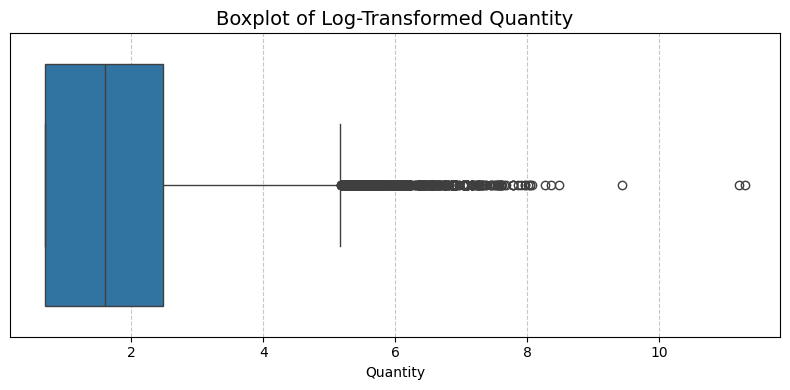

In [25]:
plt.figure(figsize=(8, 4))

sns.boxplot(x=np.log(df_retail_clean["Quantity"] + 1))
plt.title("Boxplot of Log-Transformed Quantity", fontsize=14)
plt.yticks([])
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

<b>-></b> Calculate IQR to detect outliers <br>
<b>-></b> Define an upper threshold

In [26]:
Q1 = df_retail_clean['Quantity'].quantile(0.25)
Q3 = df_retail_clean['Quantity'].quantile(0.75)
IQR = Q3 - Q1


upper_bound = Q3 + 1.5 * IQR
print("Upper bound for outliers in Quantity column is: ", upper_bound)

Upper bound for outliers in Quantity column is:  26.0


In [27]:
print("Total number of rows with Quantity greater than upper bound: ",len( df_retail_clean[df_retail_clean['Quantity'] > upper_bound]))

Total number of rows with Quantity greater than upper bound:  27120


<b>-></b> While the IQR method flagged Quantity values over 23.5 as outliers, I use business-defined thresholds to categorize orders:

* Small (< 1,000 units)
* Mid-size (1,000–29,999 units)
* Large (30,000+ units)

This can help isolate bulk or anomalous orders for deeper business insight, especially regarding inventory and customer behavior.

In [28]:
print("Records with 'Small' quantity: ", (df_retail_clean["Quantity"] < 1000).sum())
print("Records with 'Mid-size' quantity: ", ((df_retail_clean["Quantity"] >= 1000) & (df_retail_clean["Quantity"] < 30000)).sum())
print("Records with 'Large' quantity: ", (df_retail_clean["Quantity"]>=30000).sum())

Records with 'Small' quantity:  524800
Records with 'Mid-size' quantity:  115
Records with 'Large' quantity:  2


<b>-></b> Create a new column 'QuantityBracket' based on the three categories from Quantity column

In [29]:
conditions = [
    df_retail_clean['Quantity'] < 1000, 
    (df_retail_clean['Quantity'] >= 1000) & (df_retail_clean['Quantity'] < 30000), 
    df_retail_clean["Quantity"]>=30000
]

categories = ['Small', 'Mid-size', 'Large']

df_retail_clean['QuantityBracket'] = np.select(conditions, categories, default='Unknown')

<b>-></b> Convert Year column to integers for proper aggregation <br>
<b>-></b> Convert Month column to string for easier filtering and labeling in visualizations

In [30]:
# df_retail_clean['CustomerID'] = df_retail_clean['CustomerID'].astype('int64')
df_retail_clean['Year'] = df_retail_clean['Year'].astype('int64')
df_retail_clean['Month'] = df_retail_clean['Month'].astype('str')

#### Save cleaned dataset for further analysis

In [31]:
df_retail_clean.to_csv("cleaned_online_retail.csv", index=False)